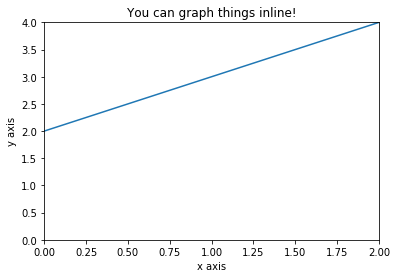

In [2]:
import matplotlib.pyplot as plt
plt.plot([0,2],[2,4])
plt.axis(xmin=0,xmax=2,ymin=0,ymax=4)
plt.title("You can graph things inline!")
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show() # this is not necessary for notebooks, but is when you run the python script

In [3]:
import jellyfish.graphs as graphs
import matplotlib.pyplot as plt
import networkx as nx

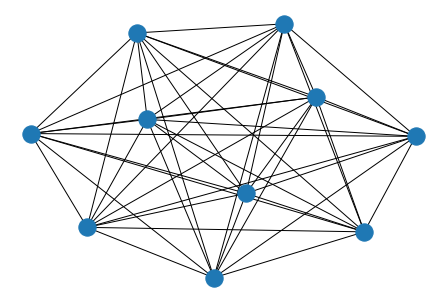

In [4]:
# This is a handy thing to use if you're making changes to a source file
import importlib
importlib.reload(graphs)

G = graphs.complete(10)
nx.draw(G)

# networkx uses matplotlib to draw things, 
# so you can save the image like this
plt.savefig("../figures/complete_graph.png")

plt.show()

Implement Jellyfish. There’s some placeholder code in jellyfish/graphs.py. We’ve provided some tests that partially check your implementation, notes on running them are in the README.




In [5]:
def jellyfish(n, degree, num_hosts):
    """
    Generates a Jellyfish graph

    Parameters
    ----------
    n: int
      Number of switches
    
    degree: int
      degree for each switch (# of ports)
      Called "k" in jellyfish paper

    num_hosts: int
      number of edges dedicated to hosts per switch. Called "k-r" in jellyfish paper
      (r edges per switch go to other switches).

    Returns
    -------
    networkx.Graph
      A jellyfish graph
    """
    r = degree - num_hosts
    jelly = nx.random_regular_graph(r, n)
    for server_id in range(n , n + num_hosts*n):
        jelly.add_node(server_id, type='host')
        jelly.add_edge(server_id, server_id - n)
    jelly.nodes.data('type', default='switch')

    return jelly

Reproduce Figures 1a and 1b (with or without the “concentric rings”). You will need to implement some code in jellyfish/cli.py to draw the graphs. There are some examples of how to draw graphs in the example notebook in the notebooks directory.


In [6]:
jellyfish_graph = jellyfish(16,4,1)

In [7]:
def draw_jellyfish(n, G):
    node_color_array = ['#1f78b4']*len(G.nodes) 
    node_color_array[-n:] = ['#b41f96']*n
    nx.draw_networkx(G,node_color=node_color_array,node_size=25,with_labels=False)
    plt.show()


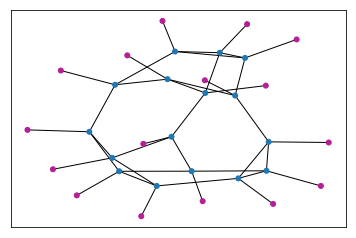

In [8]:
draw_jellyfish(16,jellyfish(16,4,1))

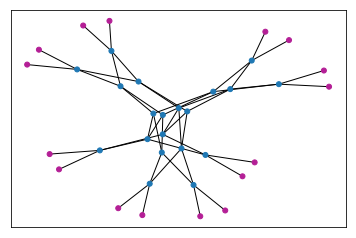

In [9]:
G = graphs.fat_tree(4)
n = len(G.nodes)
node_color_array = ['#1f78b4']*n 
node_color_array[-16:] = ['#b41f96']*16
nx.draw_networkx(G,node_color=node_color_array,node_size=25,with_labels=False)
plt.show()

Reproduce Figure 1c. Hint: you may notice that the Jellyfish parameters are not specified, but since it is compared to a “same-equipment fat tree” we can assume something about the degree of each switch.

In [10]:
import numpy as np

#large_jellyfish = jellyfish(98,14,7)
large_jellyfish = nx.random_regular_graph(7, 98) #jellyfish(98,14,7) #nx.random_regular_graph(7, 98)#jellyfish(98,14,7)
large_fattree = graphs.fat_tree(14)

path_lengths = {}
path_lengths['Jellyfish'] = np.array([0]*6)
path_lengths['Fat-tree'] = np.array([0]*6)

length_dict = dict(nx.shortest_path_length(large_jellyfish))
for n in large_jellyfish.nodes:
    for m in large_jellyfish.nodes:
        if n != m:
            length = length_dict[n][m]
            if length == 12:
                print(n,m)
                print()
            path_lengths['Jellyfish'][length+1] += 1
            
length_dict = dict(nx.shortest_path_length(large_fattree))
for n in large_fattree.nodes:
    for m in large_fattree.nodes:
        if n != m:
            length = length_dict[n][m]
            path_lengths['Fat-tree'][length-1] += 1
            
path_lengths['Jellyfish'] = [x/sum(path_lengths['Jellyfish']) for x in path_lengths['Jellyfish']]
path_lengths['Fat-tree'] = [x/sum(path_lengths['Fat-tree']) for x in path_lengths['Fat-tree']]



{'Jellyfish': [0.0, 0.0, 0.07216494845360824, 0.35766884073216915, 0.5482852934988428, 0.02188091731537976], 'Fat-tree': [0.004753820033955857, 0.030107526881720432, 0.11726089417091115, 0.19898132427843804, 0.144199207696661, 0.5046972269383135]}
1.0 1.0


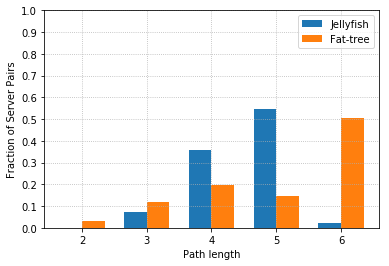

In [11]:
print(path_lengths)
print(sum(path_lengths['Jellyfish']), sum(path_lengths['Fat-tree']))
width = 0.35
plt.bar(np.arange(2,7) - width/2,path_lengths['Jellyfish'][1:], width=width,label='Jellyfish')
plt.bar(np.arange(2,7) + width/2,path_lengths['Fat-tree'][1:], width=width,label='Fat-tree')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylabel('Fraction of Server Pairs')
plt.xlabel('Path length')
plt.legend()

plt.grid(b=True,linestyle=':')

plt.show()

Reproduce Figure 2a. You may use the following theorem to estimate the bisection bandwidth of a random regular graph (note that it gives a slightly worse bound than Bollobás 1988).

Definition: Let G be a graph with vertices V, and let S be a subset of its vertices. The boundary of S, denoted by ∂S, is the set of edges between S and the remaining vertices in the graph (V \ S).

Theorem: Let G be a random regular graph with n nodes and degree r. Fix any set of nodes S, where |S| ≤ n/2. If r ≥ 3, then with probability approaching one as n goes to infinity, |∂S| ≥ (1 - sqrt(ln(2)/r)) * r/2 * |S|.

In [12]:
def bisection_bandwidth(n,r):
    return (1 - np.sqrt(np.log(2)/r)) * r/2 * n/2

In [13]:
def construct_line(N,k,r_range):
    line_x = []
    line_y = []
    for r in range(r_range[0],r_range[1]):
        bi_band = bisection_bandwidth(N,r)
        line_rate_bandwidth = (N * (k-r))/2 # The number of connections from servers to switches divided by 2
        num_servers = line_rate_bandwidth*2
        line_y.append(bi_band/line_rate_bandwidth)
        line_x.append(num_servers)
    return line_x, line_y

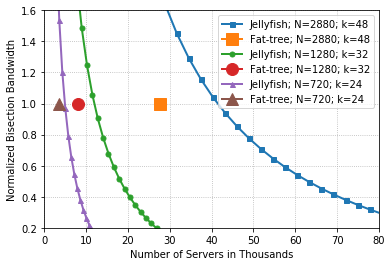

In [14]:
jelly_labels = ['Jellyfish; N=2880; k=48', 'Jellyfish; N=1280; k=32','Jellyfish; N=720; k=24']
fat_labels = ['Fat-tree; N=2880; k=48', 'Fat-tree; N=1280; k=32','Fat-tree; N=720; k=24']
N = [2880,1280,720]
k = [48,32,24]
r_range = [(20,40),(11,27),(8,21)]
labels = zip(jelly_labels,fat_labels)
markers = ['s','o','^']
params = zip(N,k,r_range,labels,markers)

for N,k,r_range,label,marker in params:
    line_x, line_y = construct_line(N,k,r_range)
    #     print(line_x[0],line_x[-1])
    #     print(line_y[0],line_y[-1])
    #     print(len(line_x))
    fat_tree_servers = np.power(k,3)/4
    fat_tree_bandwidth_normalized = (np.power(k,3)/8)/(np.power(k,3)/4/ 2)
    plt.plot(line_x, line_y,label=label[0], marker=marker, markersize=5, linewidth=2)
    plt.plot(fat_tree_servers,fat_tree_bandwidth_normalized,label=label[1], marker=marker, markersize=12, linewidth=2)

plt.xticks(np.arange(0, 80001, step=10000), labels=np.arange(0, 81, step=10))
plt.yticks(np.arange(0.2, 1.7, step=0.2))
plt.grid(b=True,linestyle=':')
plt.xlim(0,80000) 
plt.ylim(0.2,1.6) 
plt.ylabel('Normalized Bisection Bandwidth')
plt.xlabel('Number of Servers in Thousands')
plt.legend()
plt.show()
    


Reproduce Figure 2b




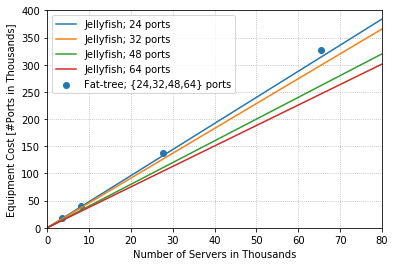

In [15]:
jelly_labels = ['Jellyfish; 24 ports', 'Jellyfish; 32 ports', 'Jellyfish; 48 ports', 'Jellyfish; 64 ports']
fat_label = 'Fat-tree; {24,32,48,64} ports'
num_ports = np.array([24,32,48,64])
r = np.array([19,25,36,47])

params = zip(num_ports,r,jelly_labels)

for k,r,label in params:
    num_servers = np.arange(0,80001,step=10000)
    cost = k * num_servers / (k-r)
    plt.plot(num_servers,cost,label=label)


fat_servers = np.power(num_ports,3)/4
fat_ports = num_ports*(np.power(num_ports/2,2) + num_ports * num_ports)

plt.scatter(fat_servers,fat_ports,marker='o', label=fat_label)    

plt.xticks(np.arange(0, 80001, step=10000), labels=np.arange(0, 81, step=10))
plt.yticks(np.arange(0, 400001, step=50000), labels=np.arange(0, 401, step=50))
plt.grid(b=True,linestyle=':')
plt.xlim(0,80000) 
plt.ylim(0,400000) 
plt.ylabel('Equipment Cost [#Ports in Thousands]')
plt.xlabel('Number of Servers in Thousands')
plt.legend()
plt.show()


Reproduce Figure 9. More information about ECMP is available at wikipedia, RFC 2991, and other places online.


In [16]:
def path_contains(path,n1,n2):
    for i in range(len(path)-1):
        if path[i] == n1 and path[i+1] == n2:
            return True
    return False
            

In [26]:
import random

def eight_way(paths,count):
    #print(len(paths))
    if len(paths) <= 8:
        path = random.choice(paths)
    else:
        path = random.choice(paths[:8])
    #print(path)
    for i in range(len(path)-1):
        if (path[i],path[i+1]) in count:
            count[(path[i],path[i+1])] += 1
            
def sixty_four_way(paths,count):
    #print(len(paths))
    if len(paths) <= 64:
        path = random.choice(paths)
    else:
        path = random.choice(paths[:8])
    #print(path)
    for i in range(len(path)-1):
        if (path[i],path[i+1]) in count:
            count[(path[i],path[i+1])] += 1

In [27]:
from collections import defaultdict

large_jellyfish = jellyfish(98,14,7)
print(len(large_jellyfish.edges))
print(len(large_jellyfish.nodes))
#length_dict = dict(nx.all_pairs_shortest_path(large_jellyfish))  
arr_sol = []

#count = defaultdict(int) 
edge_pairs = list(large_jellyfish.edges)+[(n2,n1) for (n1,n2) in large_jellyfish.edges]
count_eight = dict((e,0) for e in edge_pairs)
count_sixty = dict((e,0) for e in edge_pairs)
total_eight = 0
for n1 in large_jellyfish.nodes:
    n2 = np.random.choice(list(large_jellyfish.nodes))
    if n1 != n2:
        paths = nx.all_shortest_paths(large_jellyfish,source=n1,target=n2)
        #print(list(paths))
        eight_way(list(paths),count_eight)
        total += 1
    
total_sixty = 0
for n1 in large_jellyfish.nodes:
    n2 = np.random.choice(list(large_jellyfish.nodes))
    if n1 != n2:
        paths = nx.all_shortest_paths(large_jellyfish,source=n1,target=n2)
        #print(list(paths))
        sixty_four_way(list(paths),count_sixty)
        total_sixty += 1
print(total)

1029
784
1565


In [32]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

count_eight_shortest = dict((e,0) for e in edge_pairs)
total_eight_shortest = 0
for n1 in large_jellyfish.nodes:
    n2 = np.random.choice(list(large_jellyfish.nodes))
    if n1 != n2:
        paths = k_shortest_paths(large_jellyfish, n1, n2, 8)
        #print(list(paths))
        eight_way(list(paths),count_eight_shortest)
        total_eight_shortest += 1

7477
2058


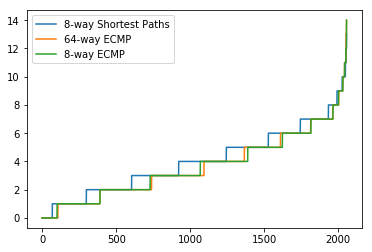

In [33]:
print(sum(count_sixty.values()))
print(len(count_sixty.values()))

plt.plot(sorted(count_eight_shortest.values()), label="8-way Shortest Paths")
plt.plot(sorted(count_sixty.values()), label="64-way ECMP")
plt.plot(sorted(count_eight.values()), label="8-way ECMP")
plt.legend()

Reproduce Table 1


In [34]:
import matplotlib.pyplot as plt
import jellyfish.graphs as graphs
import networkx as nx
from mininet.log import lg
import mininet.clean
from mininet.cli import CLI
import jellyfish
import numpy as np

*** Mininet must run as root.


NameError: name 'exit' is not defined